# Assignment 4: Benchmarking Neural Nets with the XOR Problem

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For references, you may refer to my [lecture 13](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe) if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python/Tensorflow and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_4_ann.ipynb**.



In [53]:
# You might want to use the following packages
import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the train/validate/test set. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)
[[ 0.32899354 -0.04980721]
 [-0.30510503  0.86161839]
 [ 0.93593054  0.08483319]
 ...
 [-0.09707271  0.01637483]
 [ 1.32668631 -0.22926908]
 [ 0.79993374  0.86445101]]


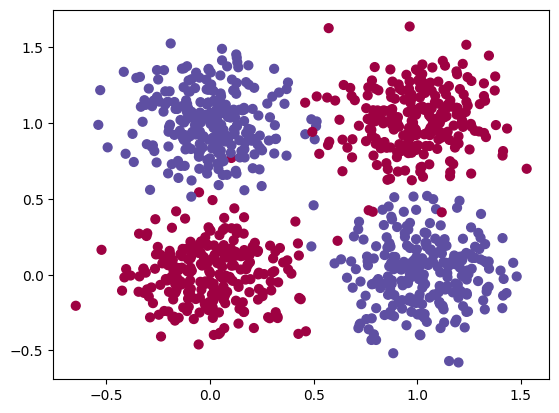

In [54]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
print(X_train)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.


In [68]:
import tensorflow as tf
from tensorflow import keras
# Your code here!

my_model = keras.Sequential([
    keras.layers.Dense(2, activation='relu'), #input
    keras.layers.Dense(4, activation='relu'), #hidden
    keras.layers.Dense(1, activation='sigmoid') #output
])

my_model.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])

fit_history = my_model.fit(X_train, y_train, batch_size=20, epochs=100,
                           validation_data=(X_val, y_val))


Epoch 1/100
36/36 [==============================] - 1s 6ms/step - loss: 0.6656 - accuracy: 0.5681 - val_loss: 0.6560 - val_accuracy: 0.5750
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.5806 - val_loss: 0.6489 - val_accuracy: 0.5875
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.5861 - val_loss: 0.6423 - val_accuracy: 0.5750
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6458 - val_loss: 0.6355 - val_accuracy: 0.5500
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.6366 - accuracy: 0.6542 - val_loss: 0.6277 - val_accuracy: 0.5625
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6667 - val_loss: 0.6191 - val_accuracy: 0.5875
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6736 - val_loss: 0.6093 - val_accuracy: 0.6250
Epoch 8/100
3

- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [163]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder
import math

class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, n0, n1, n2, alpha=0.01):
        """
        @param: n0: Number of nodes in the input layer
        @param: n1: Number of nodes in the hidden layer
        @param: n2: Number of nodes in the output layer
        @param: alpha: The Learning Rate
        """

        # SUBTASK 1: Initialize the parameters to random values.
        np.random.seed(42)
        self.W1 = np.random.randn(n1, n0)
        self.b1 = np.random.uniform(n1, 1)/10
        self.W2 = np.random.randn(n2, n1)
        self.b2 = np.random.randn(n2, n1)/10

        # Configure the learning rate
        self.alpha = alpha
        # One-hot encoder for labels
        self.encoder = OneHotEncoder(sparse=False)

    def softmax(self, z):
        e_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return e_z / np.sum(e_z, axis=0, keepdims=True)
    
    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: A1: saved value of the output of the hidden layer
        @return: A2: activated return value of the output layer.
        """
        # SUBTASK 2: Implement Forward propagation.
        # Note: that you must implement tanh activation for the hiden layer
        # and softmax for the output layer

        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1)
        A2 = self.softmax(Z2)
        return A1, A2


    def loss(self, X, y):
        """
        Evaluate the total loss on the dataset
        @param: X: features
        @param: y: labels
        @return: L: the loss value
        """


        # SUBTASK 3: Calculate the loss using Cross-Entropy
        # You will need to return the average loss on the data
        # Hint: Use A2 to calculate the loss
        A1, A2 = self.forward_pass(X)
        p = 1 / (1 + np.exp(-A2))
        # Another Hint: First, you may want to convert the lable y into a one-hot vector
        Y = self.one_hot(y)
        L = (-Y*np.log(p)) - ((1-Y)*np.log(1-p))

        return np.mean(L)

    def backward_pass(self, A1, A2, X, y):
        """
        @param: X: feature
        @param: y: label
        @param: A1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the loss gradient of W1
        @return: db1: the loss gradient of b1
        @return: dW2: the loss gradient of W2
        @return: db2: the loss gradient of b2
        """

        # You DO NOT CHANGE this function, ...
        # unless you are advanced and want to use different activation function for your forward pass
        # This is an elegant partial derivative of cross entropy with softmax
        # Ref document: https://deepnotes.io/softmax-crossentropy
        m   = y.shape[0]
        dZ2 = A2 - self.one_hot(y)
        dW2 = np.dot(dZ2, A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply( np.dot( self.W2.T, dZ2), 1-np.power( A1, 2))
        dW1 = np.dot(dZ1, X.T)/m
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, Y_val):
        """
        Learns parameters for the neural network and returns the model.

        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Input checks: X and X_val needs to be in the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T
        if (X_val.shape[0] > X_val.shape[1]): X_val = X_val.T

        # Gradient descent
        for i in range(0, epochs):

            # SUBTASK 4: Compute the forward, backward, and gradient descent parameter update
            # Step 1: Forward pass
            A1, A2 = self.forward_pass(X)

            # Step 2: Backward pass
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)

            # Step 3: Gradient Descent
            self.W1 = self.W1 - (self.alpha * dW1)
            self.b1 = self.b1 - (self.alpha * db1)
            self.W2 = self.W2 - (self.alpha * dW2)
            self.b2 = self.b2 - (self.alpha * db2)

            # Print the loss and validation accuracy every 10 epochs.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f"
                      %(i,epochs, self.loss(X, y), self.evaluate(X, y),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def predict(self, X):
        """
        Predict label vector y
        """
        # check X for the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T

        # SUBTASK 5: Implement the prediction process.
        # Hint: It should include a forward pass, and then use the class with higher probability.
        fp = self.forward_pass(X)
        y_hat = []
        for i in range(len(fp[1][0])):
            if fp[1][0][i] > fp[1][1][i]:
                y_hat.append(0)
            else:
                y_hat.append(1)
        return np.array(y_hat)


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        m = y.shape[0]
        y_hat = self.predict(X)
        correct_y = (y_hat == y).astype(int)

        return sum(correct_y)/m


    def one_hot(self, y):
        """
        Utility function: Convert a label vector to one-hot vector
        """
        Y = self.encoder.fit_transform(y.reshape(len(y),1))
        return Y.T # Transpose to get into same shape 1 x m


    def plot_decision_boundary(self, X, y):
        """
        Utility Function: Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version.

C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 0/1000 - loss: 0.711183 - accuracy: 0.612500 - val_loss: 0.723382 - val_accuracy: 0.537500
Epoch 10/1000 - loss: 0.710575 - accuracy: 0.615278 - val_loss: 0.722104 - val_accuracy: 0.537500
Epoch 20/1000 - loss: 0.709994 - accuracy: 0.615278 - val_loss: 0.720983 - val_accuracy: 0.537500
Epoch 30/1000 - loss: 0.709429 - accuracy: 0.613889 - val_loss: 0.719982 - val_accuracy: 0.537500
Epoch 40/1000 - loss: 0.708873 - accuracy: 0.615278 - val_loss: 0.719077 - val_accuracy: 0.537500
Epoch 50/1000 - loss: 0.708324 - accuracy: 0.616667 - val_loss: 0.718248 - val_accuracy: 0.550000
Epoch 60/1000 - loss: 0.707779 - accuracy: 0.619444 - val_loss: 0.717478 - val_accuracy: 0.537500
Epoch 70/1000 - loss: 0.707237 - accuracy: 0.622222 - val_loss: 0.716756 - val_accuracy: 0.537500
Epoch 80/1000 - loss: 0.706697 - accuracy: 0.622222 - val_loss: 0.716072 - val_accuracy: 0.550000
Epoch 90/1000 - loss: 0.706160 - accuracy: 0.627778 - val_loss: 0.715420 - val_accuracy: 0.550000
Epoch 100/1000 - loss

C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 120/1000 - loss: 0.704564 - accuracy: 0.641667 - val_loss: 0.713599 - val_accuracy: 0.550000
Epoch 130/1000 - loss: 0.704037 - accuracy: 0.645833 - val_loss: 0.713024 - val_accuracy: 0.550000
Epoch 140/1000 - loss: 0.703513 - accuracy: 0.644444 - val_loss: 0.712461 - val_accuracy: 0.550000
Epoch 150/1000 - loss: 0.702991 - accuracy: 0.645833 - val_loss: 0.711908 - val_accuracy: 0.550000
Epoch 160/1000 - loss: 0.702472 - accuracy: 0.647222 - val_loss: 0.711363 - val_accuracy: 0.550000
Epoch 170/1000 - loss: 0.701955 - accuracy: 0.654167 - val_loss: 0.710825 - val_accuracy: 0.562500
Epoch 180/1000 - loss: 0.701440 - accuracy: 0.658333 - val_loss: 0.710293 - val_accuracy: 0.562500
Epoch 190/1000 - loss: 0.700928 - accuracy: 0.661111 - val_loss: 0.709766 - val_accuracy: 0.562500
Epoch 200/1000 - loss: 0.700417 - accuracy: 0.662500 - val_loss: 0.709244 - val_accuracy: 0.575000
Epoch 210/1000 - loss: 0.699909 - accuracy: 0.666667 - val_loss: 0.708724 - val_accuracy: 0.575000
Epoch 220/

C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 240/1000 - loss: 0.698394 - accuracy: 0.683333 - val_loss: 0.707184 - val_accuracy: 0.587500
Epoch 250/1000 - loss: 0.697893 - accuracy: 0.683333 - val_loss: 0.706675 - val_accuracy: 0.587500
Epoch 260/1000 - loss: 0.697393 - accuracy: 0.684722 - val_loss: 0.706167 - val_accuracy: 0.575000
Epoch 270/1000 - loss: 0.696895 - accuracy: 0.686111 - val_loss: 0.705661 - val_accuracy: 0.575000
Epoch 280/1000 - loss: 0.696398 - accuracy: 0.690278 - val_loss: 0.705157 - val_accuracy: 0.575000
Epoch 290/1000 - loss: 0.695903 - accuracy: 0.693056 - val_loss: 0.704653 - val_accuracy: 0.600000
Epoch 300/1000 - loss: 0.695408 - accuracy: 0.695833 - val_loss: 0.704151 - val_accuracy: 0.587500
Epoch 310/1000 - loss: 0.694915 - accuracy: 0.700000 - val_loss: 0.703649 - val_accuracy: 0.587500
Epoch 320/1000 - loss: 0.694423 - accuracy: 0.698611 - val_loss: 0.703148 - val_accuracy: 0.587500
Epoch 330/1000 - loss: 0.693932 - accuracy: 0.706944 - val_loss: 0.702648 - val_accuracy: 0.575000
Epoch 340/

C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 360/1000 - loss: 0.692465 - accuracy: 0.708333 - val_loss: 0.701150 - val_accuracy: 0.575000
Epoch 370/1000 - loss: 0.691978 - accuracy: 0.708333 - val_loss: 0.700651 - val_accuracy: 0.575000
Epoch 380/1000 - loss: 0.691492 - accuracy: 0.709722 - val_loss: 0.700153 - val_accuracy: 0.575000
Epoch 390/1000 - loss: 0.691007 - accuracy: 0.709722 - val_loss: 0.699655 - val_accuracy: 0.587500
Epoch 400/1000 - loss: 0.690522 - accuracy: 0.718056 - val_loss: 0.699157 - val_accuracy: 0.587500
Epoch 410/1000 - loss: 0.690039 - accuracy: 0.720833 - val_loss: 0.698659 - val_accuracy: 0.600000
Epoch 420/1000 - loss: 0.689556 - accuracy: 0.722222 - val_loss: 0.698161 - val_accuracy: 0.587500
Epoch 430/1000 - loss: 0.689073 - accuracy: 0.726389 - val_loss: 0.697663 - val_accuracy: 0.587500
Epoch 440/1000 - loss: 0.688592 - accuracy: 0.729167 - val_loss: 0.697165 - val_accuracy: 0.587500
Epoch 450/1000 - loss: 0.688111 - accuracy: 0.731944 - val_loss: 0.696668 - val_accuracy: 0.600000
Epoch 460/

C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 480/1000 - loss: 0.686672 - accuracy: 0.748611 - val_loss: 0.695174 - val_accuracy: 0.625000
Epoch 490/1000 - loss: 0.686194 - accuracy: 0.750000 - val_loss: 0.694677 - val_accuracy: 0.650000
Epoch 500/1000 - loss: 0.685716 - accuracy: 0.758333 - val_loss: 0.694179 - val_accuracy: 0.662500
Epoch 510/1000 - loss: 0.685239 - accuracy: 0.768056 - val_loss: 0.693681 - val_accuracy: 0.662500
Epoch 520/1000 - loss: 0.684762 - accuracy: 0.780556 - val_loss: 0.693183 - val_accuracy: 0.700000
Epoch 530/1000 - loss: 0.684286 - accuracy: 0.787500 - val_loss: 0.692685 - val_accuracy: 0.712500
Epoch 540/1000 - loss: 0.683810 - accuracy: 0.801389 - val_loss: 0.692187 - val_accuracy: 0.712500
Epoch 550/1000 - loss: 0.683335 - accuracy: 0.813889 - val_loss: 0.691688 - val_accuracy: 0.725000
Epoch 560/1000 - loss: 0.682860 - accuracy: 0.825000 - val_loss: 0.691190 - val_accuracy: 0.737500
Epoch 570/1000 - loss: 0.682386 - accuracy: 0.834722 - val_loss: 0.690691 - val_accuracy: 0.750000
Epoch 580/

C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 590/1000 - loss: 0.681439 - accuracy: 0.845833 - val_loss: 0.689694 - val_accuracy: 0.762500
Epoch 600/1000 - loss: 0.680966 - accuracy: 0.848611 - val_loss: 0.689195 - val_accuracy: 0.762500
Epoch 610/1000 - loss: 0.680494 - accuracy: 0.851389 - val_loss: 0.688696 - val_accuracy: 0.762500
Epoch 620/1000 - loss: 0.680021 - accuracy: 0.855556 - val_loss: 0.688197 - val_accuracy: 0.775000
Epoch 630/1000 - loss: 0.679550 - accuracy: 0.859722 - val_loss: 0.687698 - val_accuracy: 0.775000
Epoch 640/1000 - loss: 0.679078 - accuracy: 0.861111 - val_loss: 0.687199 - val_accuracy: 0.775000
Epoch 650/1000 - loss: 0.678607 - accuracy: 0.862500 - val_loss: 0.686699 - val_accuracy: 0.775000
Epoch 660/1000 - loss: 0.678136 - accuracy: 0.866667 - val_loss: 0.686200 - val_accuracy: 0.787500
Epoch 670/1000 - loss: 0.677666 - accuracy: 0.869444 - val_loss: 0.685700 - val_accuracy: 0.800000
Epoch 680/1000 - loss: 0.677195 - accuracy: 0.870833 - val_loss: 0.685200 - val_accuracy: 0.812500
Epoch 690/

C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 710/1000 - loss: 0.675786 - accuracy: 0.879167 - val_loss: 0.683700 - val_accuracy: 0.825000
Epoch 720/1000 - loss: 0.675317 - accuracy: 0.879167 - val_loss: 0.683200 - val_accuracy: 0.825000
Epoch 730/1000 - loss: 0.674847 - accuracy: 0.881944 - val_loss: 0.682699 - val_accuracy: 0.825000
Epoch 740/1000 - loss: 0.674378 - accuracy: 0.886111 - val_loss: 0.682199 - val_accuracy: 0.837500
Epoch 750/1000 - loss: 0.673909 - accuracy: 0.886111 - val_loss: 0.681698 - val_accuracy: 0.837500
Epoch 760/1000 - loss: 0.673441 - accuracy: 0.888889 - val_loss: 0.681197 - val_accuracy: 0.850000
Epoch 770/1000 - loss: 0.672972 - accuracy: 0.891667 - val_loss: 0.680696 - val_accuracy: 0.862500
Epoch 780/1000 - loss: 0.672503 - accuracy: 0.891667 - val_loss: 0.680195 - val_accuracy: 0.862500
Epoch 790/1000 - loss: 0.672035 - accuracy: 0.891667 - val_loss: 0.679694 - val_accuracy: 0.862500
Epoch 800/1000 - loss: 0.671566 - accuracy: 0.894444 - val_loss: 0.679192 - val_accuracy: 0.875000
Epoch 810/

C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 830/1000 - loss: 0.670161 - accuracy: 0.898611 - val_loss: 0.677687 - val_accuracy: 0.900000
Epoch 840/1000 - loss: 0.669692 - accuracy: 0.905556 - val_loss: 0.677185 - val_accuracy: 0.900000
Epoch 850/1000 - loss: 0.669223 - accuracy: 0.908333 - val_loss: 0.676683 - val_accuracy: 0.900000
Epoch 860/1000 - loss: 0.668755 - accuracy: 0.911111 - val_loss: 0.676181 - val_accuracy: 0.900000
Epoch 870/1000 - loss: 0.668286 - accuracy: 0.913889 - val_loss: 0.675678 - val_accuracy: 0.900000
Epoch 880/1000 - loss: 0.667817 - accuracy: 0.913889 - val_loss: 0.675175 - val_accuracy: 0.900000
Epoch 890/1000 - loss: 0.667348 - accuracy: 0.913889 - val_loss: 0.674672 - val_accuracy: 0.900000
Epoch 900/1000 - loss: 0.666879 - accuracy: 0.913889 - val_loss: 0.674169 - val_accuracy: 0.900000
Epoch 910/1000 - loss: 0.666410 - accuracy: 0.915278 - val_loss: 0.673666 - val_accuracy: 0.900000
Epoch 920/1000 - loss: 0.665941 - accuracy: 0.918056 - val_loss: 0.673163 - val_accuracy: 0.900000


C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jackh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

Epoch 930/1000 - loss: 0.665471 - accuracy: 0.918056 - val_loss: 0.672659 - val_accuracy: 0.900000
Epoch 940/1000 - loss: 0.665002 - accuracy: 0.919444 - val_loss: 0.672156 - val_accuracy: 0.912500
Epoch 950/1000 - loss: 0.664532 - accuracy: 0.920833 - val_loss: 0.671652 - val_accuracy: 0.912500
Epoch 960/1000 - loss: 0.664062 - accuracy: 0.920833 - val_loss: 0.671148 - val_accuracy: 0.912500
Epoch 970/1000 - loss: 0.663591 - accuracy: 0.922222 - val_loss: 0.670644 - val_accuracy: 0.912500
Epoch 980/1000 - loss: 0.663121 - accuracy: 0.922222 - val_loss: 0.670139 - val_accuracy: 0.912500
Epoch 990/1000 - loss: 0.662650 - accuracy: 0.922222 - val_loss: 0.669635 - val_accuracy: 0.912500
Accuracy on the test set is  0.905


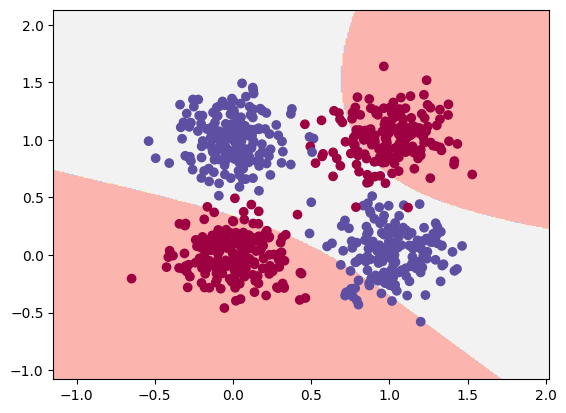

In [167]:
# MODEL 1 here
n0 = 2
n1 = 4
n2 = 2
alpha = .01
epochs = 1000

# Build a model with 3 layers
myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)


In [ ]:
# MODEL 2 here

In [ ]:
# MODEL 3 here

In [ ]:
# COMPARISONS WITH THE STANDARD LIBRARY

## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [lecture 13](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe)
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 4:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!